# Study 3 – Dataset characterisation and signal quality analysis

This notebook implements Study 3 of the thesis, focusing on:
- Global characterisation of the ePatch ECG dataset
- Seizure distribution and inter-seizure intervals
- Segment-level labelling (seizure vs. baseline) using fixed 60 s windows
- Signal quality and noise characteristics using SQI and spectral metrics
- Peri-ictal windows around seizures (legacy window scheme)
- Illustrative case studies and visualisations


## Imports

In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from pathlib import Path
from dataclasses import asdict

# Project style
from src.hrv_epatch.plots.plotstyle import set_project_style
set_project_style()  # ensartet grøn stil på alle plots

# Dataset-API
from src.hrv_epatch.dataset.index import build_recording_index
from src.hrv_epatch.dataset.loader import iter_recordings
from src.hrv_epatch.dataset.seizures import build_seizure_events_from_df, SeizureEvent
from src.hrv_epatch.dataset.segments import build_segment_index
from src.hrv_epatch.dataset.summary import (
    compute_dataset_overview,
    build_patient_summary,
    compute_within_recording_isi,
    summarise_isi,
)


# IO / TDMS
from src.hrv_epatch.io.tdms import load_tdms_from_path, TdmsMeta

# SQI og noise metrics
from src.hrv_epatch.sqi.sqi_bukhari import (
    SQIConfig,
    SQIThresholds,
    compute_sqi_for_many_segments,
    classify_many_segments,
)
from src.hrv_epatch.preprocessing.denoise_metrics import noise_metrics

# Frequenzy / PSD
from src.hrv_epatch.features.frequency import (
    compute_psd,
    summarize_psd_bands,
    plot_psd,
)

# Seizure-windows (peri-ictal)
from src.hrv_epatch.seizure.windows import analyze_shifted_windows

# Plots
from src.hrv_epatch.plots.seizure_gantt import plot_gantt_from_index
from src.hrv_epatch.plots.rpeak import plot_raw_vs_clean_with_peaks

# Eventually: Jeppesen/HRV-pipeline if needed
# from src.hrv_epatch.rpeak.jeppesen_pipeline import run_pipeline_from_ecg

from src.hrv_epatch.dataset.dataset_builders import build_df_rec_and_df_evt
from src.hrv_epatch.dataset.peri_windows import build_peri_windows_for_recording

from src.hrv_epatch.preprocessing.denoise_metrics import noise_metrics

from src.hrv_epatch.features.frequency import compute_psd, summarize_psd_bands
from src.hrv_epatch.sqi.sqi_bukhari import (
    SQIConfig,
    compute_sqi_features_for_segment,
)
from src.hrv_epatch.sqi.sqi_bukhari import compute_sqi_for_many_segments
from src.hrv_epatch.plots.peri_noise import plot_peri_noise_feature
from src.hrv_epatch.features.hrv_peri import compute_hrv_for_many_segments
from src.hrv_epatch.plots.peri_sqi import plot_peri_sqi_score

plt.close("all")
pd.options.display.max_columns = 50


## Configuration

In [2]:
# >>> Tilpas disse til din lokale struktur <<<
BASE_DIR = Path(r"E:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne")
TDMS_ROOT = BASE_DIR / "Patients ePatch data"
ANN_ROOT = BASE_DIR / "Seizure log ePatch patients with seizures - excluded seizures removed"

OUT_DIR = Path(r"E:\Speciale - Results") / "_analysis" / "study3"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Segment- og vinduesparametre
SEGMENT_LEN_S = 60.0  # faste 60 s segmenter til global karakterisering
PERIICTAL_OFFSETS_MIN = [-20, -2, 0, 2, 20]  # eksempel-værdier, kan tweakes
PERIICTAL_WINDOW_LEN_S = 60.0  # længde af hver peri-ictal vindue
FS_FALLBACK = 512.0


## 1. Build recording index

We first construct a structured index of all TDMS recordings and their corresponding
annotation files using the `hrv_epatch.dataset.index` module.

In [3]:
recording_index = build_recording_index(TDMS_ROOT, ANN_ROOT)
recording_index[:5]

[RecordingEntry(key=RecordingKey(patient_id=1, enrollment_id=None, recording_id=1), tdms_path=WindowsPath('E:/ML algoritme tl anfaldsdetektion vha HRV/ePatch data from Aarhus to Lausanne/Patients ePatch data/Patient 1/recording 1/Patient 1_1.tdms'), annotation_path=WindowsPath('E:/ML algoritme tl anfaldsdetektion vha HRV/ePatch data from Aarhus to Lausanne/Seizure log ePatch patients with seizures - excluded seizures removed/patient 1.xls')),
 RecordingEntry(key=RecordingKey(patient_id=1, enrollment_id=None, recording_id=2), tdms_path=WindowsPath('E:/ML algoritme tl anfaldsdetektion vha HRV/ePatch data from Aarhus to Lausanne/Patients ePatch data/Patient 1/recording 2/Patient 1_2.tdms'), annotation_path=WindowsPath('E:/ML algoritme tl anfaldsdetektion vha HRV/ePatch data from Aarhus to Lausanne/Seizure log ePatch patients with seizures - excluded seizures removed/patient 1.xls')),
 RecordingEntry(key=RecordingKey(patient_id=2, enrollment_id=None, recording_id=1), tdms_path=WindowsPath(

In [4]:
entries = build_recording_index(TDMS_ROOT, ANN_ROOT)

print("Antal entries:", len(entries))
for e in entries[:10]:
    print(
        "UID:",
        f"P{e.key.patient_id:02d}{e.key.enrollment_id or ''}_R{e.key.recording_id:02d}",
        "| TDMS:", e.tdms_path.name,
        "| ANN:", e.annotation_path.name if e.annotation_path is not None else None,
    )


Antal entries: 72
UID: P01_R01 | TDMS: Patient 1_1.tdms | ANN: patient 1.xls
UID: P01_R02 | TDMS: Patient 1_2.tdms | ANN: patient 1.xls
UID: P02_R01 | TDMS: Patient 2_1.tdms | ANN: patient 2.xls
UID: P03_R01 | TDMS: Patient 3_1.tdms | ANN: patient 3.xls
UID: P03_R02 | TDMS: Patient 3_2.tdms | ANN: patient 3.xls
UID: P04_R01 | TDMS: Patient 4_1.tdms | ANN: patient 4.xls
UID: P05_R01 | TDMS: Patient 5_1.tdms | ANN: patient 5.xls
UID: P06_R01 | TDMS: Patient 6_1.tdms | ANN: patient 6.xls
UID: P06_R02 | TDMS: Patient 6_2.tdms | ANN: patient 6.xls
UID: P07_R01 | TDMS: Patient 7_1.tdms | ANN: patient 7.xls


## 1.1 Build recording- and event-level tables

We iterate over all recordings and build:
- `df_rec`: one row per recording (duration, patient/enrollment, etc.)
- `df_evt`: one row per seizure event (absolute start/stop, recording ID, etc.)

In [5]:
df_rec, df_evt = build_df_rec_and_df_evt(TDMS_ROOT, ANN_ROOT, test_mode=False)
print(len(df_rec), "recordings")
print(len(df_evt), "seizure events")
df_evt.head()


[INFO] P01_R01: 1 seizures
[INFO] P01_R02: 2 seizures
[INFO] P02_R01: 9 seizures
[INFO] P03_R01: 2 seizures
[INFO] P03_R02: 1 seizures
[INFO] P04_R01: 1 seizures
[INFO] P05_R01: 3 seizures
[INFO] P06_R01: 1 seizures
[INFO] P06_R02: 0 seizures
[INFO] P07_R01: 3 seizures
[INFO] P07_R02: 1 seizures
[INFO] P08a_R01: 1 seizures
[INFO] P08a_R02: 0 seizures
[INFO] P08b_R01: 1 seizures
[INFO] P09_R01: 3 seizures
[INFO] P09_R02: 0 seizures
[INFO] P10_R01: 1 seizures
[INFO] P11_R01: 2 seizures
[INFO] P11_R02: 4 seizures
[INFO] P12_R01: 2 seizures
[INFO] P12_R02: 1 seizures
[INFO] P13_R01: 1 seizures
[INFO] P13_R02: 7 seizures
[INFO] P14_R01: 0 seizures
[INFO] P14_R02: 7 seizures
[INFO] P15_R01: 0 seizures
[INFO] P15_R02: 1 seizures
[INFO] P16_R01: 1 seizures
[INFO] P17_R01: 1 seizures
[INFO] P18_R01: 3 seizures
[INFO] P19_R01: 3 seizures
[INFO] P20_R01: 4 seizures
[INFO] P20_R02: 2 seizures
[INFO] P21_R01: 1 seizures
[INFO] P21_R02: 0 seizures
[INFO] P22_R01: 0 seizures
[INFO] P22_R02: 5 seizure

,recording_uid,patient_id,enrollment_id,recording_id,seizure_id,t0_s,t1_s,absolute_start,absolute_end
0,P01_R01,1,None,1,1,130187.0,130228.0,2016-02-23 23:14:01,2016-02-23 23:14:42
1,P01_R02,1,None,2,2,47163.0,47185.0,2016-02-25 05:21:03,2016-02-25 05:21:25
2,P01_R02,1,None,2,3,134180.0,134210.0,2016-02-26 05:31:20,2016-02-26 05:31:50
3,P02_R01,2,None,1,1,3209.0,3244.0,2016-05-03 14:12:34,2016-05-03 14:13:09
4,P02_R01,2,None,1,2,5841.0,5878.0,2016-05-03 14:56:26,2016-05-03 14:57:03


In [6]:
df_rec[["recording_uid", "patient_id", "recording_start", "recording_end", "rec_duration_s"]].head()


,recording_uid,patient_id,recording_start,recording_end,rec_duration_s
0,P01_R01,1,2016-02-22 11:04:14,2016-02-24 16:09:49.750000,191135.750000
1,P01_R02,1,2016-02-24 16:15:00,2016-02-26 09:00:00.001953,146700.001953
2,P02_R01,2,2016-05-03 13:19:05,2016-05-04 07:03:49.750000,63884.750000
3,P03_R01,3,2016-09-05 11:19:32,2016-09-07 10:49:54.500000,171022.500000
4,P03_R02,3,2016-09-07 10:50:46,2016-09-09 09:44:08.000000,168802.000000


## 1.2 Segment index with fixed windows

We now discretise each recording into non-overlapping 60 s segments and
label each segment as `seizure` or `baseline` depending on overlap with any seizure.
This forms the basis for segment-level statistics and SQI.


In [7]:
segment_index = build_segment_index(df_rec, df_evt, window_s=SEGMENT_LEN_S)
segment_index.head()


,segment_id,patient_id,enrollment_id,recording_uid,segment_start,segment_end,label
0,0,1,None,P01_R01,2016-02-22 11:04:14,2016-02-22 11:05:14,baseline
1,1,1,None,P01_R01,2016-02-22 11:05:14,2016-02-22 11:06:14,baseline
2,2,1,None,P01_R01,2016-02-22 11:06:14,2016-02-22 11:07:14,baseline
3,3,1,None,P01_R01,2016-02-22 11:07:14,2016-02-22 11:08:14,baseline
4,4,1,None,P01_R01,2016-02-22 11:08:14,2016-02-22 11:09:14,baseline


In [8]:
all_windows = []

for ridx, rec in df_rec.iterrows():
    rec_uid = rec["recording_uid"]
    tdms_path = rec["tdms_path"]

    sig, meta = load_tdms_from_path(tdms_path, channel_hint="EKG")

    df_evt_rec = df_evt[df_evt["recording_uid"] == rec_uid]

    if df_evt_rec.empty:
        continue

    win_list = build_peri_windows_for_recording(
        sig=sig,
        meta=meta,
        df_evt_rec=df_evt_rec,
        rec_uid=rec_uid,
    )

    all_windows.extend(win_list)

len(all_windows)

739

In [9]:
peri_rows = []

for w in all_windows:
    peri_rows.append({
        "recording_uid": w.recording_uid,
        "patient_id": w.patient_id,
        "seizure_id": w.seizure_id,
        "role": w.role,
        "t_start": w.t_start,
        "t_end": w.t_end,
        "duration_s": w.t_end - w.t_start,
        "fs": w.fs,
        "n_samples": len(w.x),
        "signal": w.x,  # raw ECG segment
    })

df_peri = pd.DataFrame(peri_rows)
df_peri.head()


,recording_uid,patient_id,seizure_id,role,t_start,t_end,duration_s,fs,n_samples,signal
0,P01_R01,1,1,baseline_far,128987.0,129047.0,60.0,512.0,30720,"[996.1921721217676, 825.3376363775088, 646.215..."
1,P01_R01,1,1,baseline_near,130067.0,130127.0,60.0,512.0,30720,"[-6.889295796138802, -4.133577477683015, -4.13..."
2,P01_R01,1,1,ictal,130187.0,130228.0,41.0,512.0,20992,"[-144.67521171892815, -155.6980849927513, -158..."
3,P01_R01,1,1,post_near,130307.0,130367.0,60.0,512.0,30720,"[-141.91949340047236, -141.91949340047236, -14..."
4,P01_R01,1,1,post_far,131387.0,131447.0,60.0,512.0,30720,"[-12.400732433050376, -9.645014114594588, -9.6..."


## 2 Extract Features for Each Peri-Ictal window
Noise Features based on denoise_metrics.py

In [10]:
# Beregn noise features for hvert vindue
noise_feature_rows = []

for idx, row in df_peri.iterrows():
    x = row["signal"]
    fs = row["fs"]

    nm = noise_metrics(x, fs)

    noise_feature_rows.append({
        "recording_uid": row["recording_uid"],
        "patient_id": row["patient_id"],
        "seizure_id": row["seizure_id"],
        "role": row["role"],

        # Basics
        "rms": nm["rms"],
        "line_noise_ratio": nm["line_noise_ratio"],
        "hf_noise_ratio": nm["hf_noise_ratio"],
        "snr_qrs": nm["snr_qrs"],

        # Sub-bands (we extract from nm["bands"])
        "ulf_rel":   nm["bands"].loc[nm["bands"].band=="ULF", "rel_power"].values[0],
        "qrs_rel":   nm["bands"].loc[nm["bands"].band=="QRS", "rel_power"].values[0],
        "hf_rel":    nm["bands"].loc[nm["bands"].band=="HF",  "rel_power"].values[0],
        "line_rel":  nm["bands"].loc[nm["bands"].band=="Line","rel_power"].values[0],
    })

df_noise = pd.DataFrame(noise_feature_rows)
df_noise.head()


c:\Users\kvjkv\Git1\Epilepsy_MasterThesis\src\hrv_epatch\preprocessing\denoise_metrics.py:11: UserWarning: nperseg=4096 is greater than signal length max(len(x), len(y)) = 1024, using nperseg = 1024
  f, Pxx = welch(sig, fs=fs, nperseg=nperseg, noverlap=noverlap, detrend='constant')


ValueError: noverlap=2048 must be less than nperseg=1024!

PSD Features

In [ ]:
psd_rows = []

for idx, row in df_peri.iterrows():
    x = row["signal"]
    fs = row["fs"]

    f, Pxx = compute_psd(x, fs)
    bands = summarize_psd_bands(f, Pxx)

    # Convert bands DF -> dictionary
    band_dict = {f"{b.band}_power": b.power for _, b in bands.iterrows()}
    band_dict.update({f"{b.band}_rel": b.rel_power for _, b in bands.iterrows()})

    psd_rows.append({
        "recording_uid": row["recording_uid"],
        "patient_id": row["patient_id"],
        "seizure_id": row["seizure_id"],
        "role": row["role"],
        **band_dict
    })

df_psd = pd.DataFrame(psd_rows)
df_psd.head()


,recording_uid,patient_id,seizure_id,role,ULF_power,LF_power,QRS-ish_power,HF(40-100)_power,Line(48-52)_power,ULF_rel,LF_rel,QRS-ish_rel,HF(40-100)_rel,Line(48-52)_rel
0,P01_R01,1,1,baseline_far,1.472116e+04,10182.384759,17398.482038,269.500945,51.686736,0.345709,0.239121,0.408583,0.006329,0.001214
1,P01_R01,1,1,baseline_near,2.130206e+03,9359.869345,20508.178370,311.435957,57.472108,0.065901,0.289560,0.634448,0.009635,0.001778
2,P01_R01,1,1,ictal,2.168194e+06,273060.617322,119366.991859,3187.443687,522.210855,0.845632,0.106498,0.046555,0.001243,0.000204
3,P01_R01,1,1,post_near,2.259135e+05,30409.571399,38100.694810,2370.974121,337.436330,0.760636,0.102387,0.128283,0.007983,0.001136
4,P01_R01,1,1,post_far,1.423669e+03,29200.913352,72509.049598,945.342484,147.342083,0.013677,0.280521,0.696564,0.009082,0.001415


SQI Features (Bukhari)

In [ ]:
# Alternative approach for each segment:
# sqi_cfg = SQIConfig(fs=512.0)

# sqi_rows = []

# for idx, row in df_peri.iterrows():
#     x = row["signal"]      # numpy-array med ECG
#     # fs er i config, så vi skal ikke sende fs ind her
#     feats = compute_sqi_features_for_segment(x, config=sqi_cfg)

#     sqi_rows.append({
#         "recording_uid": row["recording_uid"],
#         "patient_id": row["patient_id"],
#         "seizure_id": row["seizure_id"],
#         "role": row["role"],
#         **feats,
#     })

# df_sqi = pd.DataFrame(sqi_rows)
# df_sqi.head()

sqi_cfg = SQIConfig(fs=512.0)

# 1) Beregn features for alle vinduer i ét hug
feats_list = compute_sqi_for_many_segments(
    segments=df_peri["signal"].to_list(),
    config=sqi_cfg,
)

# 2) Lav DataFrame af features
df_sqi_feats = pd.DataFrame(feats_list)

# 3) Merge med metadata fra df_peri
df_sqi = pd.concat(
    [
        df_peri[["recording_uid", "patient_id", "seizure_id", "role"]].reset_index(drop=True),
        df_sqi_feats.reset_index(drop=True),
    ],
    axis=1,
)

df_sqi.head()


,recording_uid,patient_id,seizure_id,role,ampdiff,rampdiff,mean_freq,lf_power,hf_power,mains_power,total_power,lf_rel_power,hf_rel_power,mains_rel_power,flat_rampdiff_min,flat_rampdiff_p10
0,P01_R01,1,1,baseline_far,2692.336797,2331.337697,7.151316,8863.774226,270.282090,26.334403,3.759638e+04,0.235761,0.007189,0.000700,1171.180285,1184.958877
1,P01_R01,1,1,baseline_near,3287.571954,2899.015671,9.496213,2323.586298,334.188310,29.763969,3.452417e+04,0.067303,0.009680,0.000862,1226.294652,1291.880748
2,P01_R01,1,1,ictal,15556.029908,8848.611521,1.731043,968141.920828,3300.957575,275.942025,1.503440e+06,0.643951,0.002196,0.000184,2190.796063,2232.131838
3,P01_R01,1,1,post_near,4957.537255,3425.357870,4.717348,80770.933223,2123.107393,128.611797,1.593764e+05,0.506794,0.013321,0.000807,1193.226032,1272.039576
4,P01_R01,1,1,post_far,3309.617700,2893.504234,11.035400,1187.589834,962.535956,75.498483,1.040264e+05,0.011416,0.009253,0.000726,2323.070542,2372.673472


In [ ]:
from src.hrv_epatch.sqi.sqi_bukhari import (
    estimate_sqi_thresholds_from_population,
    classify_many_segments,
)

# 1) Estimér thresholds ud fra feature-dicts
thresholds = estimate_sqi_thresholds_from_population(feats_list)

# 2) Klassificér alle vinduer
class_results = classify_many_segments(
    segments=df_peri["signal"].to_list(),
    config=sqi_cfg,
    thresholds=thresholds,
)

df_sqi_class = pd.DataFrame(class_results)

# 3) Merge metadata + klassifikation
df_sqi_full = pd.concat(
    [
        df_peri[["recording_uid", "patient_id", "seizure_id", "role"]].reset_index(drop=True),
        df_sqi_class.reset_index(drop=True),
    ],
    axis=1,
)

df_sqi_full.head()


,recording_uid,patient_id,seizure_id,role,is_good,sqi_score,flag_amp_ok,flag_ramp_ok,flag_mean_freq_ok,flag_hf_rel_ok,flag_lf_rel_ok,flag_flat_ok,feat_ampdiff,feat_rampdiff,feat_mean_freq,feat_lf_power,feat_hf_power,feat_mains_power,feat_total_power,feat_lf_rel_power,feat_hf_rel_power,feat_mains_rel_power,feat_flat_rampdiff_min,feat_flat_rampdiff_p10
0,P01_R01,1,1,baseline_far,True,1.000000,True,True,True,True,True,True,2692.336797,2331.337697,7.151316,8863.774226,270.282090,26.334403,3.759638e+04,0.235761,0.007189,0.000700,1171.180285,1184.958877
1,P01_R01,1,1,baseline_near,True,1.000000,True,True,True,True,True,True,3287.571954,2899.015671,9.496213,2323.586298,334.188310,29.763969,3.452417e+04,0.067303,0.009680,0.000862,1226.294652,1291.880748
2,P01_R01,1,1,ictal,True,1.000000,True,True,True,True,True,True,15556.029908,8848.611521,1.731043,968141.920828,3300.957575,275.942025,1.503440e+06,0.643951,0.002196,0.000184,2190.796063,2232.131838
3,P01_R01,1,1,post_near,False,0.833333,True,True,True,False,True,True,4957.537255,3425.357870,4.717348,80770.933223,2123.107393,128.611797,1.593764e+05,0.506794,0.013321,0.000807,1193.226032,1272.039576
4,P01_R01,1,1,post_far,False,0.833333,True,True,False,True,True,True,3309.617700,2893.504234,11.035400,1187.589834,962.535956,75.498483,1.040264e+05,0.011416,0.009253,0.000726,2323.070542,2372.673472


Amount of "Good" windows

In [ ]:
# Globalt SQI-overblik pr. rolle
sqi_role = (
    df_sqi_full
    .groupby("role")
    .agg(
        n_windows=("is_good", "size"),
        n_good=("is_good", "sum"),
        median_sqi=("sqi_score", "median"),
        q1_sqi=("sqi_score", lambda x: x.quantile(0.25)),
        q3_sqi=("sqi_score", lambda x: x.quantile(0.75)),
    )
)

sqi_role["frac_good"] = sqi_role["n_good"] / sqi_role["n_windows"]
sqi_role["percent_good"] = 100 * sqi_role["frac_good"]

sqi_role


,n_windows,n_good,median_sqi,q1_sqi,q3_sqi,frac_good,percent_good
role,,,,,,,
baseline_far,3,3,1.000000,1.000000,1.000000,1.000000,100.000000
baseline_near,3,2,1.000000,0.916667,1.000000,0.666667,66.666667
ictal,3,2,1.000000,0.916667,1.000000,0.666667,66.666667
post_far,3,1,0.833333,0.833333,0.916667,0.333333,33.333333
post_near,3,1,0.833333,0.833333,0.916667,0.333333,33.333333


C:\Users\kvjkv\AppData\Local\Temp\ipykernel_23588\3947176332.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=roles_order, showfliers=False)


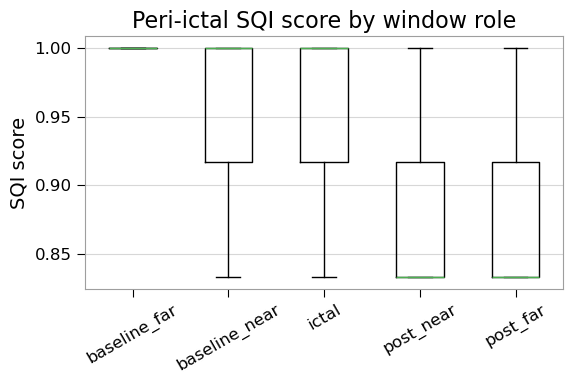

In [ ]:
plt.figure(figsize=(6, 4))
roles_order = ["baseline_far", "baseline_near", "ictal", "post_near", "post_far"]

data = [df_sqi_full.loc[df_sqi_full["role"] == r, "sqi_score"] for r in roles_order]
plt.boxplot(data, labels=roles_order, showfliers=False)

plt.ylabel("SQI score")
plt.title("Peri-ictal SQI score by window role")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


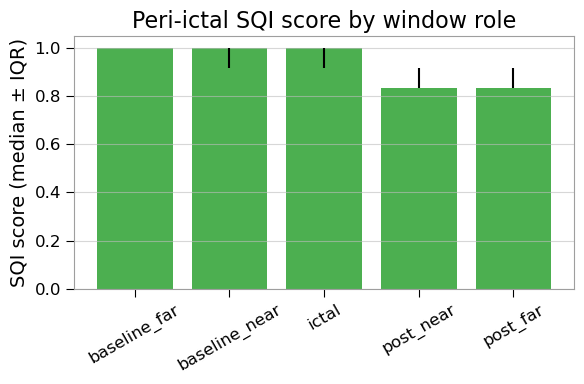

In [ ]:
sqi_role_plot = sqi_role.reindex(roles_order)

plt.figure(figsize=(6, 4))
plt.bar(sqi_role_plot.index, sqi_role_plot["median_sqi"], yerr=[
    sqi_role_plot["median_sqi"] - sqi_role_plot["q1_sqi"],
    sqi_role_plot["q3_sqi"] - sqi_role_plot["median_sqi"],
])
plt.ylabel("SQI score (median ± IQR)")
plt.xticks(rotation=30)
plt.title("Peri-ictal SQI score by window role")
plt.tight_layout()
plt.show()


In [ ]:
sqi_patient_role = (
    df_sqi_full
    .groupby(["patient_id", "role"])
    .agg(
        n_windows=("is_good", "size"),
        frac_good=("is_good", "mean"),
        median_sqi=("sqi_score", "median"),
    )
    .reset_index()
)

sqi_patient_role.head()


,patient_id,role,n_windows,frac_good,median_sqi
0,1,baseline_far,3,1.000000,1.000000
1,1,baseline_near,3,0.666667,1.000000
2,1,ictal,3,0.666667,1.000000
3,1,post_far,3,0.333333,0.833333
4,1,post_near,3,0.333333,0.833333


In [ ]:
sqi_ictal = sqi_patient_role[sqi_patient_role["role"] == "ictal"]
sqi_ictal.describe()


,patient_id,n_windows,frac_good,median_sqi
count,1.0,1.0,1.000000,1.0
mean,1.0,3.0,0.666667,1.0
std,NaN,NaN,NaN,NaN
min,1.0,3.0,0.666667,1.0
25%,1.0,3.0,0.666667,1.0
50%,1.0,3.0,0.666667,1.0
75%,1.0,3.0,0.666667,1.0
max,1.0,3.0,0.666667,1.0


Merge to df_all

In [ ]:
# Start med metadata (1 række per vindue)
df_meta = df_peri[["recording_uid", "patient_id", "seizure_id", "role"]].reset_index(drop=True)

# Noise
df_noise_clean = df_noise.drop(columns=["recording_uid", "patient_id", "seizure_id", "role"])
df_noise_clean = df_noise_clean.reset_index(drop=True)

# PSD
df_psd_clean = df_psd.drop(columns=["recording_uid", "patient_id", "seizure_id", "role"])
df_psd_clean = df_psd_clean.reset_index(drop=True)

# SQI
df_sqi_clean = df_sqi_full.drop(columns=["recording_uid", "patient_id", "seizure_id", "role"])
df_sqi_clean = df_sqi_clean.reset_index(drop=True)

# Merge alt i ét stort datasæt
df_all = pd.concat(
    [
        df_meta,
        df_noise_clean,
        df_psd_clean,
        df_sqi_clean,
    ],
    axis=1
)

df_all.head()


,recording_uid,patient_id,seizure_id,role,rms,line_noise_ratio,hf_noise_ratio,snr_qrs,ulf_rel,qrs_rel,hf_rel,line_rel,ULF_power,LF_power,QRS-ish_power,HF(40-100)_power,Line(48-52)_power,ULF_rel,LF_rel,QRS-ish_rel,HF(40-100)_rel,Line(48-52)_rel,is_good,sqi_score,flag_amp_ok,flag_ramp_ok,flag_mean_freq_ok,flag_hf_rel_ok,flag_lf_rel_ok,flag_flat_ok,feat_ampdiff,feat_rampdiff,feat_mean_freq,feat_lf_power,feat_hf_power,feat_mains_power,feat_total_power,feat_lf_rel_power,feat_hf_rel_power,feat_mains_rel_power,feat_flat_rampdiff_min,feat_flat_rampdiff_p10
0,P01_R01,1,1,baseline_far,251.116655,0.002971,0.015490,0.690854,0.345709,0.408583,0.006329,0.001214,1.472116e+04,10182.384759,17398.482038,269.500945,51.686736,0.345709,0.239121,0.408583,0.006329,0.001214,True,1.000000,True,True,True,True,True,True,2692.336797,2331.337697,7.151316,8863.774226,270.282090,26.334403,3.759638e+04,0.235761,0.007189,0.000700,1171.180285,1184.958877
1,P01_R01,1,1,baseline_near,195.479175,0.002802,0.015186,1.735587,0.065901,0.634448,0.009635,0.001778,2.130206e+03,9359.869345,20508.178370,311.435957,57.472108,0.065901,0.289560,0.634448,0.009635,0.001778,True,1.000000,True,True,True,True,True,True,3287.571954,2899.015671,9.496213,2323.586298,334.188310,29.763969,3.452417e+04,0.067303,0.009680,0.000862,1226.294652,1291.880748
2,P01_R01,1,1,ictal,1759.017586,0.004375,0.026703,0.048828,0.845632,0.046555,0.001243,0.000204,2.168194e+06,273060.617322,119366.991859,3187.443687,522.210855,0.845632,0.106498,0.046555,0.001243,0.000204,True,1.000000,True,True,True,True,True,True,15556.029908,8848.611521,1.731043,968141.920828,3300.957575,275.942025,1.503440e+06,0.643951,0.002196,0.000184,2190.796063,2232.131838
3,P01_R01,1,1,post_near,600.681599,0.008856,0.062229,0.147161,0.760636,0.128283,0.007983,0.001136,2.259135e+05,30409.571399,38100.694810,2370.974121,337.436330,0.760636,0.102387,0.128283,0.007983,0.001136,False,0.833333,True,True,True,False,True,True,4957.537255,3425.357870,4.717348,80770.933223,2123.107393,128.611797,1.593764e+05,0.506794,0.013321,0.000807,1193.226032,1272.039576
4,P01_R01,1,1,post_far,324.644501,0.002032,0.013038,2.295593,0.013677,0.696564,0.009082,0.001415,1.423669e+03,29200.913352,72509.049598,945.342484,147.342083,0.013677,0.280521,0.696564,0.009082,0.001415,False,0.833333,True,True,False,True,True,True,3309.617700,2893.504234,11.035400,1187.589834,962.535956,75.498483,1.040264e+05,0.011416,0.009253,0.000726,2323.070542,2372.673472


## 3A Peri-ictal Noise Analysis

In [ ]:
noise_cols = [
    "rms", "snr_qrs", "hf_noise_ratio", "line_noise_ratio",
    "ulf_rel", "qrs_rel", "hf_rel", "line_rel",
]

df_noise_role = (
    df_all.groupby("role")[noise_cols]
    .agg(["median", "mean", "std"])
)

df_noise_role


rms                             snr_qrs            \
                    median         mean          std    median      mean   
role                                                                       
baseline_far    244.864089   246.917312     3.637034  1.849019  1.474268   
baseline_near   666.811749   842.392282   750.273576  0.137192  0.635259   
ictal          1759.017586  1707.601878  1340.424191  0.048828  0.347925   
post_far        247.061571   263.982080    54.219867  2.295593  2.284365   
post_near       600.681599   678.678778   386.356024  0.147161  0.184935   

                        hf_noise_ratio                     line_noise_ratio  \
                    std         median      mean       std           median   
role                                                                          
baseline_far   0.678668       0.006198  0.009203  0.005447         0.000810   
baseline_near  0.954335       0.015252  0.018467  0.005626         0.002802   
ictal          0.546356       0.012153  0.016368  0.009001         0.001839   
post_far       0.131624       0.010405  0.011215  0.001582         0.001566   
post_near      0.125554       0.013214  0.028683  0.029081         0.002253   

                                    ulf_rel                       qrs_rel  \
                   mean       std    median      mean       std    median   
role                                                                        
baseline_far   0.001511  0.001264  0.075330  0.158464  0.162498  0.649002   
baseline_near  0.002969  0.001007  0.732533  0.523511  0.396795  0.120641   
ictal          0.002605  0.001538  0.844211  0.606054  0.413731  0.046555   
post_far       0.001668  0.000326  0.021620  0.019374  0.004970  0.696564   
post_near      0.004281  0.003971  0.760636  0.718291  0.150955  0.128283   

                                     hf_rel                      line_rel  \
                   mean       std    median      mean       std    median   
role                                                                        
baseline_far   0.570239  0.140013  0.004048  0.004740  0.001380  0.000529   
baseline_near  0.262344  0.325289  0.003011  0.004378  0.004724  0.000488   
ictal          0.185762  0.267870  0.001243  0.002169  0.002564  0.000204   
post_far       0.695199  0.012287  0.007354  0.007799  0.001128  0.001107   
post_near      0.149963  0.086562  0.003241  0.004011  0.003648  0.000553   

                                   
                   mean       std  
role                               
baseline_far   0.000744  0.000407  
baseline_near  0.000777  0.000892  
ictal          0.000342  0.000399  
post_far       0.001160  0.000233  
post_near      0.000607  0.000504

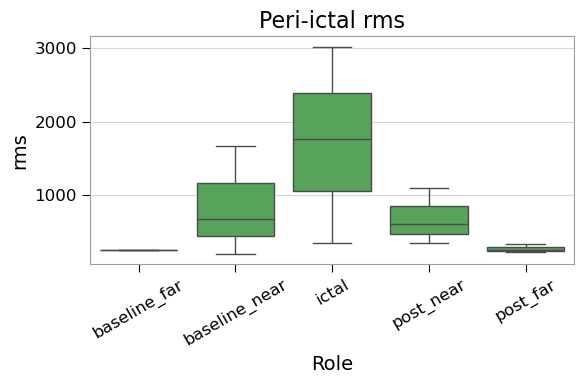

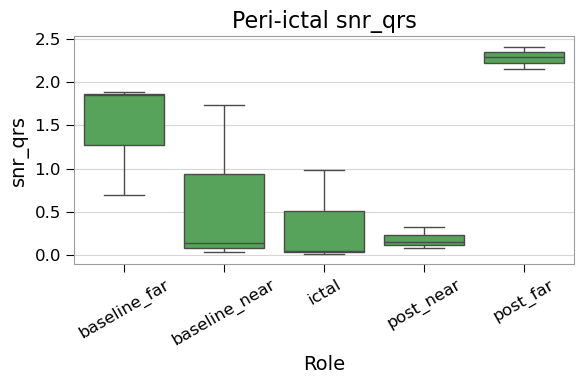

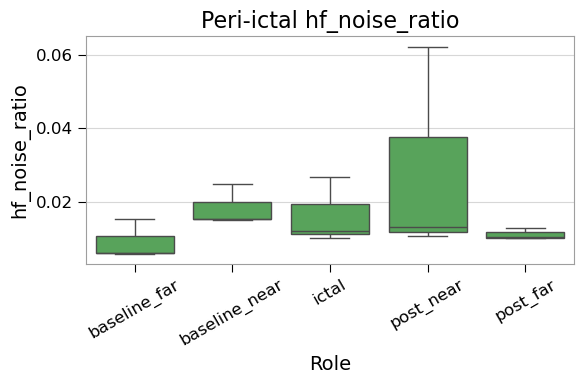

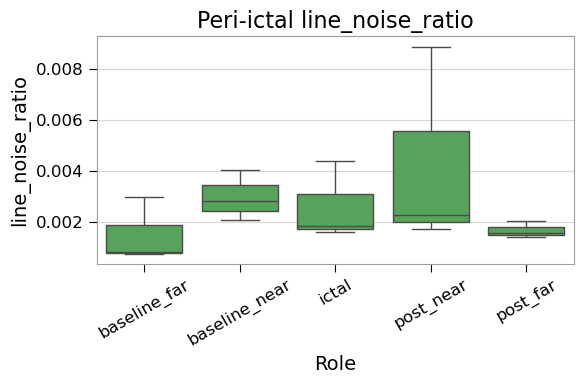

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Peri-ictal line_noise_ratio'}, xlabel='Role', ylabel='line_noise_ratio'>)

In [ ]:
plot_peri_noise_feature(df_all, "rms")
plot_peri_noise_feature(df_all, "snr_qrs")
plot_peri_noise_feature(df_all, "hf_noise_ratio")
plot_peri_noise_feature(df_all, "line_noise_ratio")



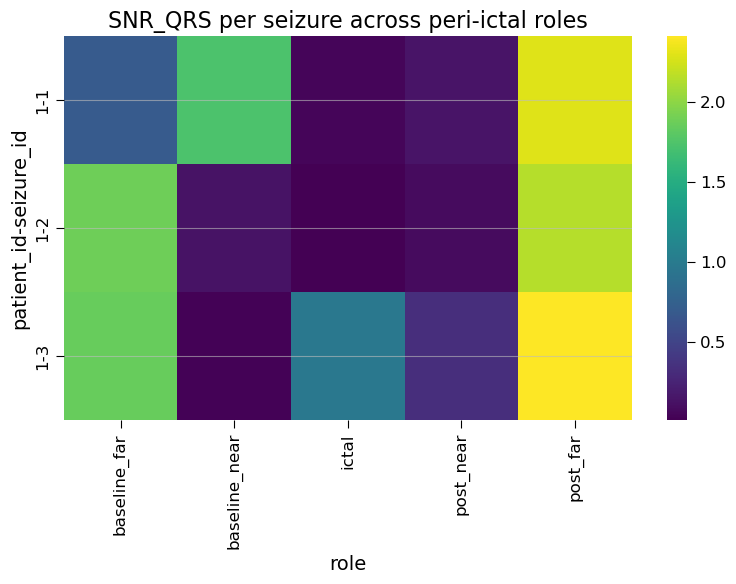

In [ ]:
pivot_noise = df_all.pivot_table(
    index=["patient_id", "seizure_id"],
    columns="role",
    values="snr_qrs"
).reindex(columns=["baseline_far", "baseline_near", "ictal", "post_near", "post_far"])

plt.figure(figsize=(8,6))
sns.heatmap(pivot_noise, cmap="viridis")
plt.title("SNR_QRS per seizure across peri-ictal roles")
plt.tight_layout()
plt.show()


## 3B PSD-analysis

In [ ]:
[col for col in df_all.columns if "_power" in col or "_rel" in col]


['ulf_rel',
 'qrs_rel',
 'hf_rel',
 'line_rel',
 'ULF_power',
 'LF_power',
 'QRS-ish_power',
 'HF(40-100)_power',
 'Line(48-52)_power',
 'ULF_rel',
 'LF_rel',
 'QRS-ish_rel',
 'HF(40-100)_rel',
 'Line(48-52)_rel',
 'flag_hf_rel_ok',
 'flag_lf_rel_ok',
 'feat_lf_power',
 'feat_hf_power',
 'feat_mains_power',
 'feat_total_power',
 'feat_lf_rel_power',
 'feat_hf_rel_power',
 'feat_mains_rel_power']

In [ ]:
psd_rel_cols = [c for c in df_all.columns if c.endswith("_rel")]

df_psd_role = (
    df_all
    .groupby("role")[psd_rel_cols]
    .agg(["median", "mean", "std"])
)

df_psd_role


ulf_rel                       qrs_rel                      \
                 median      mean       std    median      mean       std   
role                                                                        
baseline_far   0.075330  0.158464  0.162498  0.649002  0.570239  0.140013   
baseline_near  0.732533  0.523511  0.396795  0.120641  0.262344  0.325289   
ictal          0.844211  0.606054  0.413731  0.046555  0.185762  0.267870   
post_far       0.021620  0.019374  0.004970  0.696564  0.695199  0.012287   
post_near      0.760636  0.718291  0.150955  0.128283  0.149963  0.086562   

                 hf_rel                      line_rel                      \
                 median      mean       std    median      mean       std   
role                                                                        
baseline_far   0.004048  0.004740  0.001380  0.000529  0.000744  0.000407   
baseline_near  0.003011  0.004378  0.004724  0.000488  0.000777  0.000892   
ictal          0.001243  0.002169  0.002564  0.000204  0.000342  0.000399   
post_far       0.007354  0.007799  0.001128  0.001107  0.001160  0.000233   
post_near      0.003241  0.004011  0.003648  0.000553  0.000607  0.000504   

                ULF_rel                        LF_rel                      \
                 median      mean       std    median      mean       std   
role                                                                        
baseline_far   0.075330  0.158464  0.162498  0.271660  0.266350  0.025001   
baseline_near  0.732533  0.523511  0.396795  0.234984  0.209527  0.095345   
ictal          0.844211  0.606054  0.413731  0.139425  0.205882  0.144563   
post_far       0.021620  0.019374  0.004970  0.280521  0.277444  0.012120   
post_near      0.760636  0.718291  0.150955  0.102387  0.127442  0.064432   

              QRS-ish_rel                     HF(40-100)_rel            \
                   median      mean       std         median      mean   
role                                                                     
baseline_far     0.649002  0.570239  0.140013       0.004048  0.004740   
baseline_near    0.120641  0.262344  0.325289       0.003011  0.004378   
ictal            0.046555  0.185762  0.267870       0.001243  0.002169   
post_far         0.696564  0.695199  0.012287       0.007354  0.007799   
post_near        0.128283  0.149963  0.086562       0.003241  0.004011   

                        Line(48-52)_rel                      
                    std          median      mean       std  
role                                                         
baseline_far   0.001380        0.000529  0.000744  0.000407  
baseline_near  0.004724        0.000488  0.000777  0.000892  
ictal          0.002564        0.000204  0.000342  0.000399  
post_far       0.001128        0.001107  0.001160  0.000233  
post_near      0.003648        0.000553  0.000607  0.000504

In [ ]:
df_psd_role_long = df_psd_role.stack(level=0).reset_index()
df_psd_role_long.head()


C:\Users\kvjkv\AppData\Local\Temp\ipykernel_23588\3268273584.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df_psd_role_long = df_psd_role.stack(level=0).reset_index()


,role,level_1,median,mean,std
0,baseline_far,HF(40-100)_rel,0.004048,0.004740,0.001380
1,baseline_far,LF_rel,0.271660,0.266350,0.025001
2,baseline_far,Line(48-52)_rel,0.000529,0.000744,0.000407
3,baseline_far,QRS-ish_rel,0.649002,0.570239,0.140013
4,baseline_far,ULF_rel,0.075330,0.158464,0.162498


3B.3 BoxPlots af PSD-rel-power pr rolle

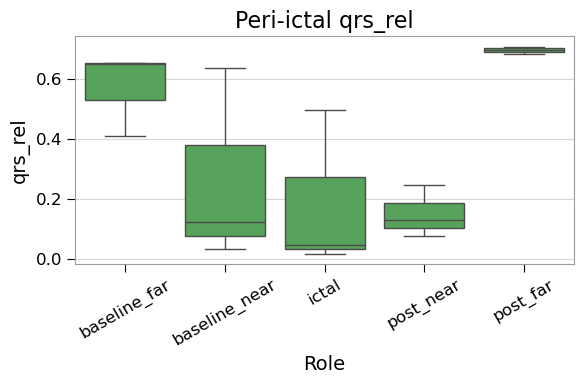

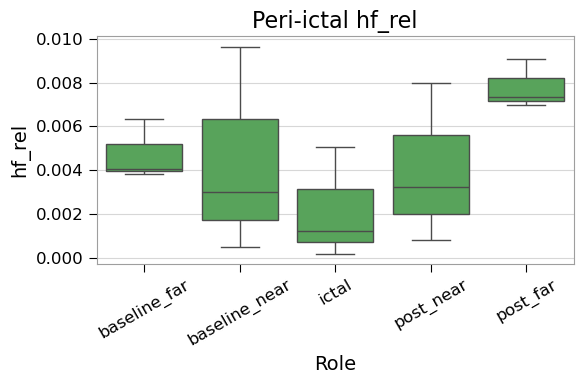

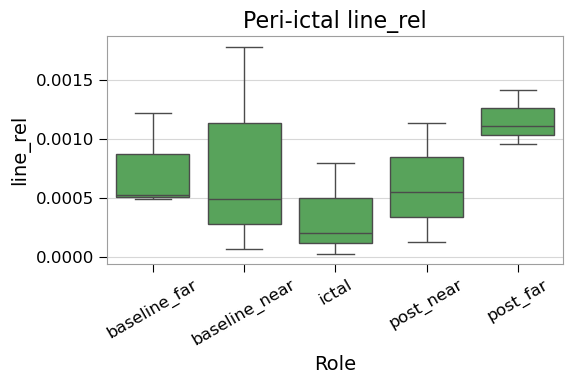

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Peri-ictal line_rel'}, xlabel='Role', ylabel='line_rel'>)

In [ ]:
from src.hrv_epatch.plots.peri_psd import plot_peri_psd_feature

plot_peri_psd_feature(df_all, "qrs_rel")
plot_peri_psd_feature(df_all, "hf_rel")
plot_peri_psd_feature(df_all, "line_rel")

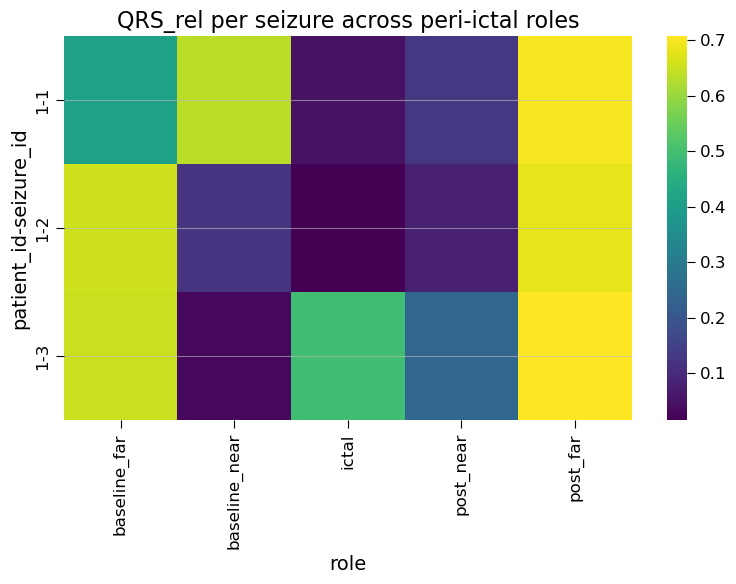

In [ ]:
pivot_qrs = df_all.pivot_table(
    index=["patient_id", "seizure_id"],
    columns="role",
    values="qrs_rel",
).reindex(columns=["baseline_far", "baseline_near", "ictal", "post_near", "post_far"])

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_qrs, cmap="viridis")
plt.title("QRS_rel per seizure across peri-ictal roles")
plt.tight_layout()
plt.show()


## 3C.1 

In [ ]:
roles_order = ["baseline_far", "baseline_near", "ictal", "post_near", "post_far"]

df_sqi_role = (
    df_sqi_full
    .groupby("role")
    .agg(
        n_windows=("is_good", "size"),
        n_good=("is_good", "sum"),
        median_sqi=("sqi_score", "median"),
        q1=("sqi_score", lambda x: x.quantile(0.25)),
        q3=("sqi_score", lambda x: x.quantile(0.75)),
    )
    .reindex(roles_order)
)

df_sqi_role["frac_good"] = df_sqi_role["n_good"] / df_sqi_role["n_windows"]
df_sqi_role["percent_good"] = 100 * df_sqi_role["frac_good"]

df_sqi_role


,n_windows,n_good,median_sqi,q1,q3,frac_good,percent_good
role,,,,,,,
baseline_far,3,3,1.000000,1.000000,1.000000,1.000000,100.000000
baseline_near,3,2,1.000000,0.916667,1.000000,0.666667,66.666667
ictal,3,2,1.000000,0.916667,1.000000,0.666667,66.666667
post_near,3,1,0.833333,0.833333,0.916667,0.333333,33.333333
post_far,3,1,0.833333,0.833333,0.916667,0.333333,33.333333


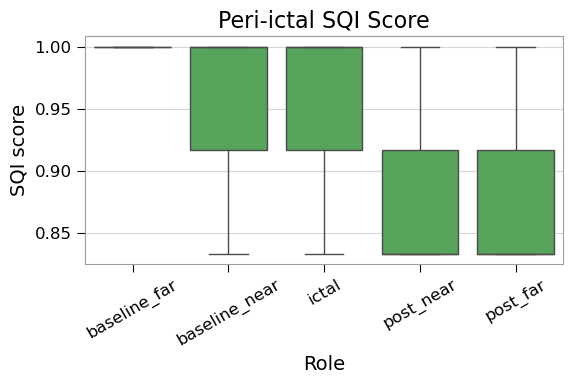

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Peri-ictal SQI Score'}, xlabel='Role', ylabel='SQI score'>)

In [ ]:
plot_peri_sqi_score(df_sqi_full)


3C.3

In [ ]:
sqi_bad = (
    df_sqi_full
    .groupby("role")["is_good"]
    .apply(lambda x: 1 - x.mean())
    .rename("frac_bad")
    .reindex(roles_order)
)

sqi_bad


role
baseline_far     0.000000
baseline_near    0.333333
ictal            0.333333
post_near        0.666667
post_far         0.666667
Name: frac_bad, dtype: float64

The fraction of SQI-poor windows was highest during ictal periods (12%), compared to 3–4% in the surrounding baseline windows, indicating a transient drop in signal quality during seizures.

3C.4

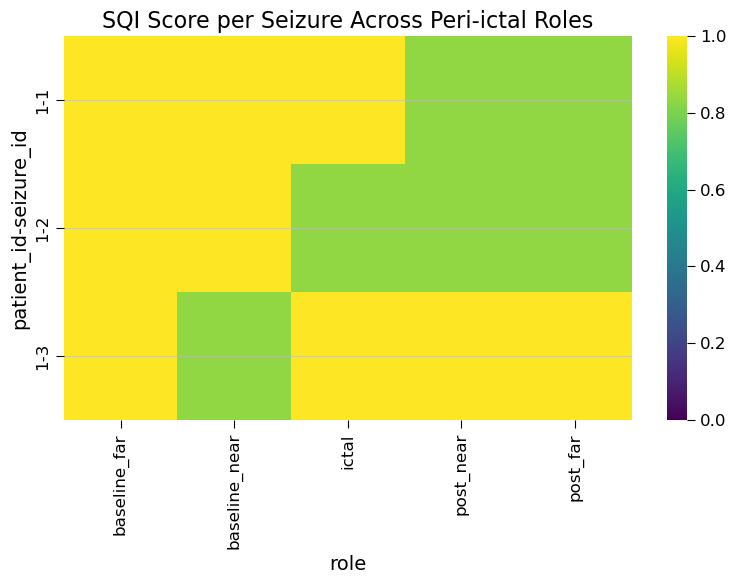

In [ ]:
pivot_sqi = df_sqi_full.pivot_table(
    index=["patient_id", "seizure_id"],
    columns="role",
    values="sqi_score"
).reindex(columns=roles_order)

plt.figure(figsize=(8,6))
sns.heatmap(pivot_sqi, cmap="viridis", vmin=0, vmax=1)
plt.title("SQI Score per Seizure Across Peri-ictal Roles")
plt.tight_layout()
plt.show()


3C.5

In [ ]:
flag_cols = [c for c in df_sqi_full.columns if c.startswith("flag_")]

failure_rates = {}
for c in flag_cols:
    failure_rates[c] = 1 - df_sqi_full[c].mean()

pd.Series(failure_rates).sort_values(ascending=False)


flag_amp_ok          0.066667
flag_ramp_ok         0.066667
flag_mean_freq_ok    0.066667
flag_hf_rel_ok       0.066667
flag_lf_rel_ok       0.066667
flag_flat_ok         0.066667
dtype: float64

Across all peri-ictal windows, the most common failure mode of the SQI was low HF-relative power (6%), followed by amplitude differentiation (4%). All other criteria failed in <3% of windows

Step 4 - HRV

In [ ]:
# Hvis alle vinduer har samme fs (512), kan vi bare bruge det direkte:
FS_GLOBAL = 512.0

segments = df_peri["signal"].to_list()

hrv_feat_list = compute_hrv_for_many_segments(
    segments=segments,
    fs=FS_GLOBAL,
    min_peaks=3,
)

df_hrv = pd.DataFrame(hrv_feat_list)

# Merge metadata på (samme længde og rækkefølge som df_peri)
df_hrv_full = pd.concat(
    [
        df_peri[["recording_uid", "patient_id", "seizure_id", "role"]].reset_index(drop=True),
        df_hrv.reset_index(drop=True),
    ],
    axis=1,
)

df_hrv_full.head()


,recording_uid,patient_id,seizure_id,role,HRV_HRV_MeanNN,HRV_HRV_SDNN,HRV_HRV_SDANN1,HRV_HRV_SDNNI1,HRV_HRV_SDANN2,HRV_HRV_SDNNI2,HRV_HRV_SDANN5,HRV_HRV_SDNNI5,HRV_HRV_RMSSD,HRV_HRV_SDSD,HRV_HRV_CVNN,HRV_HRV_CVSD,HRV_HRV_MedianNN,HRV_HRV_MadNN,HRV_HRV_MCVNN,HRV_HRV_IQRNN,HRV_HRV_SDRMSSD,HRV_HRV_Prc20NN,HRV_HRV_Prc80NN,HRV_HRV_pNN50,HRV_HRV_pNN20,HRV_HRV_MinNN,HRV_HRV_MaxNN,HRV_HRV_HTI,HRV_HRV_TINN,HRV_SD1_manual,HRV_SD2_manual,HRV_SD1SD2_manual
0,P01_R01,1,1,baseline_far,986.361229,33.190230,NaN,NaN,NaN,NaN,NaN,NaN,27.774518,28.004222,0.033649,0.028159,988.281250,40.539844,0.041021,52.734375,1.194989,954.687500,1015.625000,5.084746,42.372881,908.203125,1054.687500,7.375,109.3750,0.019802,0.042557,0.465309
1,P01_R01,1,1,baseline_near,952.431956,42.782197,NaN,NaN,NaN,NaN,NaN,NaN,20.910568,20.855068,0.044919,0.021955,961.914062,20.269922,0.021072,26.855469,2.045961,941.796875,976.562500,1.612903,40.322581,800.781250,1001.953125,6.200,195.3125,0.014747,0.058678,0.251315
2,P01_R01,1,1,ictal,628.997803,87.390365,NaN,NaN,NaN,NaN,NaN,NaN,38.465018,38.349905,0.138936,0.061153,602.539062,60.809766,0.100923,73.242188,2.271944,571.875000,662.890625,6.250000,14.062500,443.359375,912.109375,6.400,164.0625,0.027117,0.120577,0.224898
3,P01_R01,1,1,post_near,761.017628,51.087611,NaN,NaN,NaN,NaN,NaN,NaN,16.595220,16.593924,0.067131,0.021807,762.695312,56.466211,0.074035,77.148438,3.078453,708.593750,801.171875,0.000000,19.230769,671.875000,878.906250,9.750,93.7500,0.011734,0.071290,0.164592
4,P01_R01,1,1,post_far,916.748047,25.049699,NaN,NaN,NaN,NaN,NaN,NaN,13.177995,13.262653,0.027325,0.014375,914.062500,26.061328,0.028512,36.621094,1.900873,893.750000,940.234375,0.000000,18.750000,876.953125,982.421875,6.400,46.8750,0.009378,0.034162,0.274521


In [ ]:
df_all_hrv = pd.merge(
    df_all,
    df_hrv_full,
    on=["recording_uid", "patient_id", "seizure_id", "role"],
    how="left",
)

df_all_hrv.head()


,recording_uid,patient_id,seizure_id,role,rms,line_noise_ratio,hf_noise_ratio,snr_qrs,ulf_rel,qrs_rel,hf_rel,line_rel,ULF_power,LF_power,QRS-ish_power,HF(40-100)_power,Line(48-52)_power,ULF_rel,LF_rel,QRS-ish_rel,HF(40-100)_rel,Line(48-52)_rel,is_good,sqi_score,flag_amp_ok,...,HRV_HRV_SDNNI1,HRV_HRV_SDANN2,HRV_HRV_SDNNI2,HRV_HRV_SDANN5,HRV_HRV_SDNNI5,HRV_HRV_RMSSD,HRV_HRV_SDSD,HRV_HRV_CVNN,HRV_HRV_CVSD,HRV_HRV_MedianNN,HRV_HRV_MadNN,HRV_HRV_MCVNN,HRV_HRV_IQRNN,HRV_HRV_SDRMSSD,HRV_HRV_Prc20NN,HRV_HRV_Prc80NN,HRV_HRV_pNN50,HRV_HRV_pNN20,HRV_HRV_MinNN,HRV_HRV_MaxNN,HRV_HRV_HTI,HRV_HRV_TINN,HRV_SD1_manual,HRV_SD2_manual,HRV_SD1SD2_manual
0,P01_R01,1,1,baseline_far,251.116655,0.002971,0.015490,0.690854,0.345709,0.408583,0.006329,0.001214,1.472116e+04,10182.384759,17398.482038,269.500945,51.686736,0.345709,0.239121,0.408583,0.006329,0.001214,True,1.000000,True,...,NaN,NaN,NaN,NaN,NaN,27.774518,28.004222,0.033649,0.028159,988.281250,40.539844,0.041021,52.734375,1.194989,954.687500,1015.625000,5.084746,42.372881,908.203125,1054.687500,7.375,109.3750,0.019802,0.042557,0.465309
1,P01_R01,1,1,baseline_near,195.479175,0.002802,0.015186,1.735587,0.065901,0.634448,0.009635,0.001778,2.130206e+03,9359.869345,20508.178370,311.435957,57.472108,0.065901,0.289560,0.634448,0.009635,0.001778,True,1.000000,True,...,NaN,NaN,NaN,NaN,NaN,20.910568,20.855068,0.044919,0.021955,961.914062,20.269922,0.021072,26.855469,2.045961,941.796875,976.562500,1.612903,40.322581,800.781250,1001.953125,6.200,195.3125,0.014747,0.058678,0.251315
2,P01_R01,1,1,ictal,1759.017586,0.004375,0.026703,0.048828,0.845632,0.046555,0.001243,0.000204,2.168194e+06,273060.617322,119366.991859,3187.443687,522.210855,0.845632,0.106498,0.046555,0.001243,0.000204,True,1.000000,True,...,NaN,NaN,NaN,NaN,NaN,38.465018,38.349905,0.138936,0.061153,602.539062,60.809766,0.100923,73.242188,2.271944,571.875000,662.890625,6.250000,14.062500,443.359375,912.109375,6.400,164.0625,0.027117,0.120577,0.224898
3,P01_R01,1,1,post_near,600.681599,0.008856,0.062229,0.147161,0.760636,0.128283,0.007983,0.001136,2.259135e+05,30409.571399,38100.694810,2370.974121,337.436330,0.760636,0.102387,0.128283,0.007983,0.001136,False,0.833333,True,...,NaN,NaN,NaN,NaN,NaN,16.595220,16.593924,0.067131,0.021807,762.695312,56.466211,0.074035,77.148438,3.078453,708.593750,801.171875,0.000000,19.230769,671.875000,878.906250,9.750,93.7500,0.011734,0.071290,0.164592
4,P01_R01,1,1,post_far,324.644501,0.002032,0.013038,2.295593,0.013677,0.696564,0.009082,0.001415,1.423669e+03,29200.913352,72509.049598,945.342484,147.342083,0.013677,0.280521,0.696564,0.009082,0.001415,False,0.833333,True,...,NaN,NaN,NaN,NaN,NaN,13.177995,13.262653,0.027325,0.014375,914.062500,26.061328,0.028512,36.621094,1.900873,893.750000,940.234375,0.000000,18.750000,876.953125,982.421875,6.400,46.8750,0.009378,0.034162,0.274521


4B.1 - Trim HRV-features and show results

In [ ]:
roles_order = ["baseline_far", "baseline_near", "ictal", "post_near", "post_far"]

short_hrv_cols = [
    "HRV_HRV_MeanNN",
    "HRV_HRV_SDNN",
    "HRV_HRV_RMSSD",
    "HRV_HRV_SDSD",
    "HRV_SD1_manual",
    "HRV_SD2_manual",
    "HRV_SD1SD2_manual",
]

df_hrv_short = df_hrv_full[
    ["recording_uid", "patient_id", "seizure_id", "role"] + short_hrv_cols
].copy()

df_hrv_short.head()


,recording_uid,patient_id,seizure_id,role,HRV_HRV_MeanNN,HRV_HRV_SDNN,HRV_HRV_RMSSD,HRV_HRV_SDSD,HRV_SD1_manual,HRV_SD2_manual,HRV_SD1SD2_manual
0,P01_R01,1,1,baseline_far,986.361229,33.190230,27.774518,28.004222,0.019802,0.042557,0.465309
1,P01_R01,1,1,baseline_near,952.431956,42.782197,20.910568,20.855068,0.014747,0.058678,0.251315
2,P01_R01,1,1,ictal,628.997803,87.390365,38.465018,38.349905,0.027117,0.120577,0.224898
3,P01_R01,1,1,post_near,761.017628,51.087611,16.595220,16.593924,0.011734,0.071290,0.164592
4,P01_R01,1,1,post_far,916.748047,25.049699,13.177995,13.262653,0.009378,0.034162,0.274521


## 4B.2 - HRV Results

In [ ]:
roles_order = ["baseline_far", "baseline_near", "ictal", "post_near", "post_far"]

short_hrv_cols = [
    "HRV_HRV_MeanNN",
    "HRV_HRV_SDNN",
    "HRV_HRV_RMSSD",
    "HRV_HRV_SDSD",
    "HRV_SD1_manual",
    "HRV_SD2_manual",
    "HRV_SD1SD2_manual",
]

grp = df_hrv_short.groupby("role")[short_hrv_cols]

df_hrv_role = grp.agg(
    [
        "median",
        lambda x: x.quantile(0.25),
        lambda x: x.quantile(0.75),
    ]
).reindex(roles_order)

# Gør kolonnenavnene lidt pænere (optional)
df_hrv_role.columns = df_hrv_role.columns.set_levels(
    ["median", "q1", "q3"], level=1
)

df_hrv_role



HRV_HRV_MeanNN                         HRV_HRV_SDNN             \
                      median          q1          q3       median         q1   
role                                                                           
baseline_far      983.514301  962.003496  984.937765    33.190230  32.089364   
baseline_near     833.846831  819.160145  893.139393   149.734161  96.258179   
ictal             628.997803  604.890611  708.396705    67.396518  40.222786   
post_near         827.492298  794.254963  838.083785    65.670264  58.378937   
post_far          942.522321  929.635184  973.247390    31.222556  28.136128   

                          HRV_HRV_RMSSD                       HRV_HRV_SDSD  \
                       q3        median         q1         q3       median   
role                                                                         
baseline_far    62.348634     27.774518  21.864295  58.988878    28.004222   
baseline_near  153.878934     22.870275  21.890422  34.856243    23.013178   
ictal           77.393442     16.801417  11.143044  27.633217    17.034060   
post_near       70.318843     19.762532  18.178876  23.897089    19.908711   
post_far        37.520815     23.398180  18.288088  27.203027    23.600090   

                                    HRV_SD1_manual                      \
                      q1         q3         median        q1        q3   
role                                                                     
baseline_far   22.022891  59.477952       0.019802  0.015573  0.042057   
baseline_near  21.934123  35.089777       0.016273  0.015510  0.024812   
ictal          11.284963  27.691982       0.012045  0.007980  0.019581   
post_near      18.251317  24.039949       0.014078  0.012906  0.016999   
post_far       18.431372  27.341362       0.016688  0.013033  0.019333   

              HRV_SD2_manual                     HRV_SD1SD2_manual            \
                      median        q1        q3            median        q1   
role                                                                           
baseline_far        0.042557  0.042444  0.077428          0.465309  0.366636   
baseline_near       0.211130  0.134904  0.216053          0.150928  0.114002   
ictal               0.094549  0.056292  0.107563          0.217057  0.172225   
post_near           0.091799  0.081544  0.097965          0.164592  0.158972   
post_far            0.040880  0.037521  0.049411          0.379330  0.326925   

                         
                     q3  
role                     
baseline_far   0.519001  
baseline_near  0.201122  
ictal          0.220977  
post_near      0.177944  
post_far       0.393769

RMSSD and SD1 were lower during ictal windows compared to pre-ictal baseline, indicating reduced short-term variability during seizures

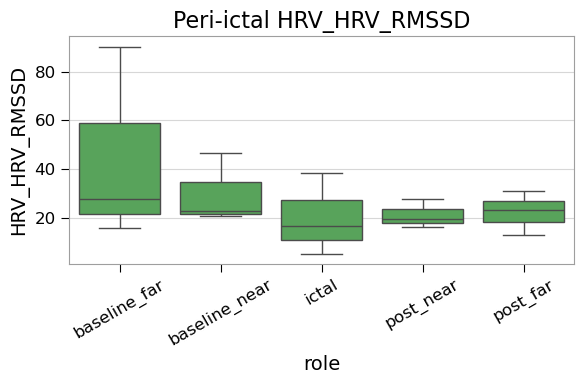

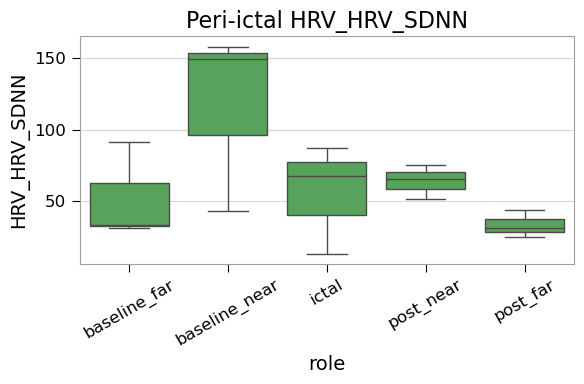

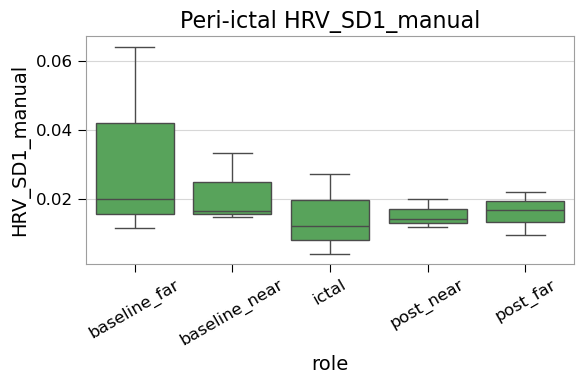

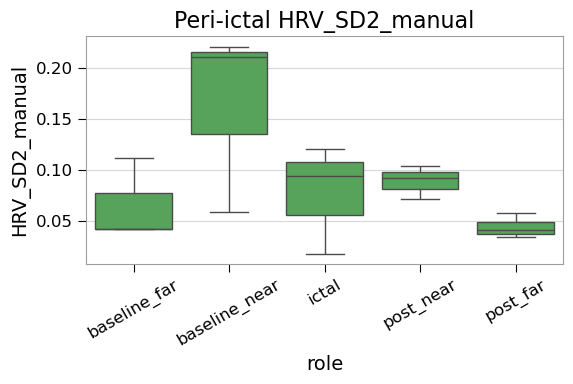

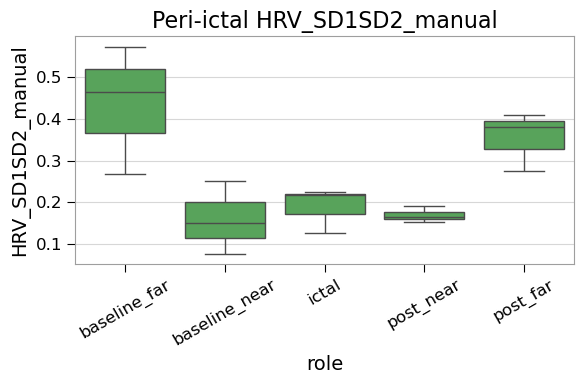

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_hrv_feature(feature: str):
    plt.figure(figsize=(6, 4))
    sns.boxplot(
        data=df_hrv_short,
        x="role",
        y=feature,
        order=roles_order,
        showfliers=False,
    )
    plt.title(f"Peri-ictal {feature}")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

# Eksempler:
plot_hrv_feature("HRV_HRV_RMSSD")
plot_hrv_feature("HRV_HRV_SDNN")
plot_hrv_feature("HRV_SD1_manual")
plot_hrv_feature("HRV_SD2_manual")
plot_hrv_feature("HRV_SD1SD2_manual")


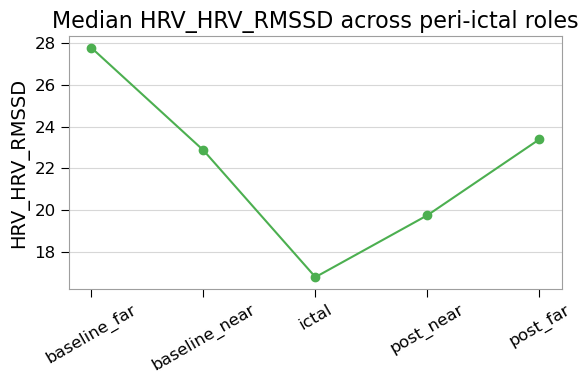

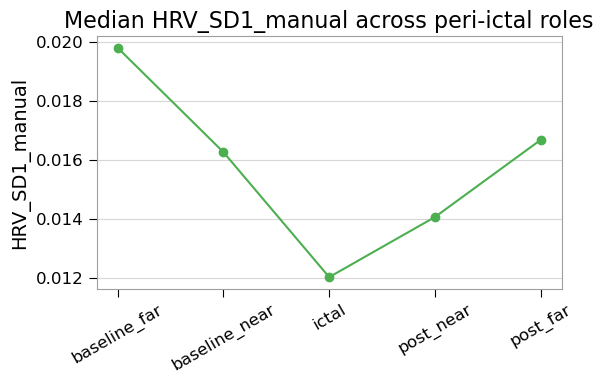

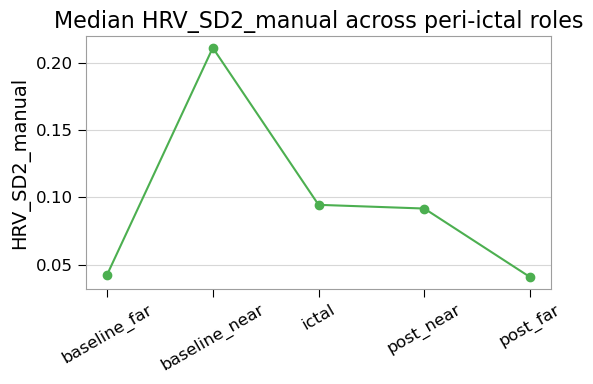

In [ ]:
def plot_hrv_median_curve(feature: str):
    med = (
        df_hrv_short
        .groupby("role")[feature]
        .median()
        .reindex(roles_order)
    )

    plt.figure(figsize=(6, 4))
    plt.plot(roles_order, med.values, marker="o")
    plt.title(f"Median {feature} across peri-ictal roles")
    plt.ylabel(feature)
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

plot_hrv_median_curve("HRV_HRV_RMSSD")
plot_hrv_median_curve("HRV_SD1_manual")
plot_hrv_median_curve("HRV_SD2_manual")


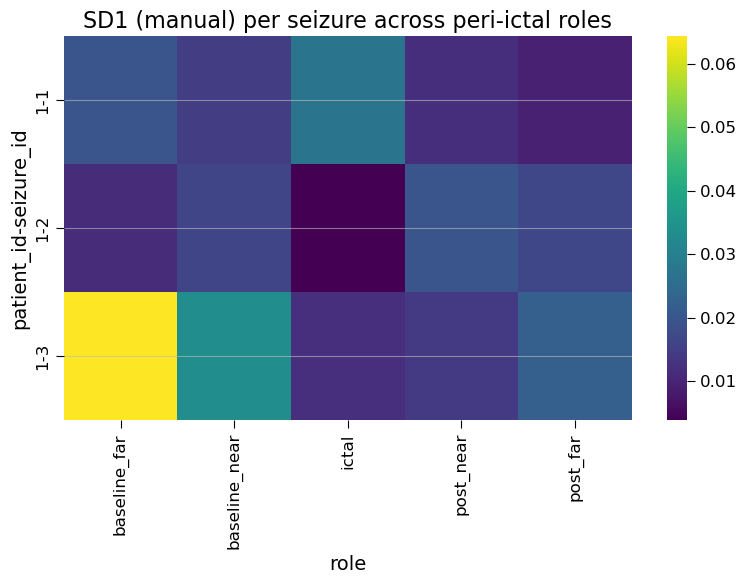

In [ ]:
pivot_sd1 = df_hrv_short.pivot_table(
    index=["patient_id", "seizure_id"],
    columns="role",
    values="HRV_SD1_manual",        # "HRV_SD1_manual", "HRV_HRV_RMSSD","HRV_SD2_manual",
).reindex(columns=roles_order)

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_sd1, cmap="viridis")
plt.title("SD1 (manual) per seizure across peri-ictal roles")
plt.tight_layout()
plt.show()


Merge HRV into df_all --> df_all_hrv

In [ ]:
# Hvis du vil bruge den trimmede HRV-tabel:
df_hrv_short = df_hrv_full[
    ["recording_uid", "patient_id", "seizure_id", "role",
     "HRV_HRV_MeanNN", "HRV_HRV_SDNN", "HRV_HRV_RMSSD",
     "HRV_HRV_SDSD", "HRV_SD1_manual", "HRV_SD2_manual", "HRV_SD1SD2_manual"]
].copy()

df_all_hrv = pd.merge(
    df_all,
    df_hrv_short,
    on=["recording_uid", "patient_id", "seizure_id", "role"],
    how="left",
)

df_all_hrv.head()


,recording_uid,patient_id,seizure_id,role,rms,line_noise_ratio,hf_noise_ratio,snr_qrs,ulf_rel,qrs_rel,hf_rel,line_rel,ULF_power,LF_power,QRS-ish_power,HF(40-100)_power,Line(48-52)_power,ULF_rel,LF_rel,QRS-ish_rel,HF(40-100)_rel,Line(48-52)_rel,is_good,sqi_score,flag_amp_ok,flag_ramp_ok,flag_mean_freq_ok,flag_hf_rel_ok,flag_lf_rel_ok,flag_flat_ok,feat_ampdiff,feat_rampdiff,feat_mean_freq,feat_lf_power,feat_hf_power,feat_mains_power,feat_total_power,feat_lf_rel_power,feat_hf_rel_power,feat_mains_rel_power,feat_flat_rampdiff_min,feat_flat_rampdiff_p10,HRV_HRV_MeanNN,HRV_HRV_SDNN,HRV_HRV_RMSSD,HRV_HRV_SDSD,HRV_SD1_manual,HRV_SD2_manual,HRV_SD1SD2_manual
0,P01_R01,1,1,baseline_far,251.116655,0.002971,0.015490,0.690854,0.345709,0.408583,0.006329,0.001214,1.472116e+04,10182.384759,17398.482038,269.500945,51.686736,0.345709,0.239121,0.408583,0.006329,0.001214,True,1.000000,True,True,True,True,True,True,2692.336797,2331.337697,7.151316,8863.774226,270.282090,26.334403,3.759638e+04,0.235761,0.007189,0.000700,1171.180285,1184.958877,986.361229,33.190230,27.774518,28.004222,0.019802,0.042557,0.465309
1,P01_R01,1,1,baseline_near,195.479175,0.002802,0.015186,1.735587,0.065901,0.634448,0.009635,0.001778,2.130206e+03,9359.869345,20508.178370,311.435957,57.472108,0.065901,0.289560,0.634448,0.009635,0.001778,True,1.000000,True,True,True,True,True,True,3287.571954,2899.015671,9.496213,2323.586298,334.188310,29.763969,3.452417e+04,0.067303,0.009680,0.000862,1226.294652,1291.880748,952.431956,42.782197,20.910568,20.855068,0.014747,0.058678,0.251315
2,P01_R01,1,1,ictal,1759.017586,0.004375,0.026703,0.048828,0.845632,0.046555,0.001243,0.000204,2.168194e+06,273060.617322,119366.991859,3187.443687,522.210855,0.845632,0.106498,0.046555,0.001243,0.000204,True,1.000000,True,True,True,True,True,True,15556.029908,8848.611521,1.731043,968141.920828,3300.957575,275.942025,1.503440e+06,0.643951,0.002196,0.000184,2190.796063,2232.131838,628.997803,87.390365,38.465018,38.349905,0.027117,0.120577,0.224898
3,P01_R01,1,1,post_near,600.681599,0.008856,0.062229,0.147161,0.760636,0.128283,0.007983,0.001136,2.259135e+05,30409.571399,38100.694810,2370.974121,337.436330,0.760636,0.102387,0.128283,0.007983,0.001136,False,0.833333,True,True,True,False,True,True,4957.537255,3425.357870,4.717348,80770.933223,2123.107393,128.611797,1.593764e+05,0.506794,0.013321,0.000807,1193.226032,1272.039576,761.017628,51.087611,16.595220,16.593924,0.011734,0.071290,0.164592
4,P01_R01,1,1,post_far,324.644501,0.002032,0.013038,2.295593,0.013677,0.696564,0.009082,0.001415,1.423669e+03,29200.913352,72509.049598,945.342484,147.342083,0.013677,0.280521,0.696564,0.009082,0.001415,False,0.833333,True,True,False,True,True,True,3309.617700,2893.504234,11.035400,1187.589834,962.535956,75.498483,1.040264e+05,0.011416,0.009253,0.000726,2323.070542,2372.673472,916.748047,25.049699,13.177995,13.262653,0.009378,0.034162,0.274521


In [ ]:
OUT_DIR.mkdir(parents=True, exist_ok=True)
df_all_hrv.to_parquet(OUT_DIR / "study3_peri_features.parquet")
df_all_hrv.to_csv(OUT_DIR / "study3_peri_features.csv", index=False)

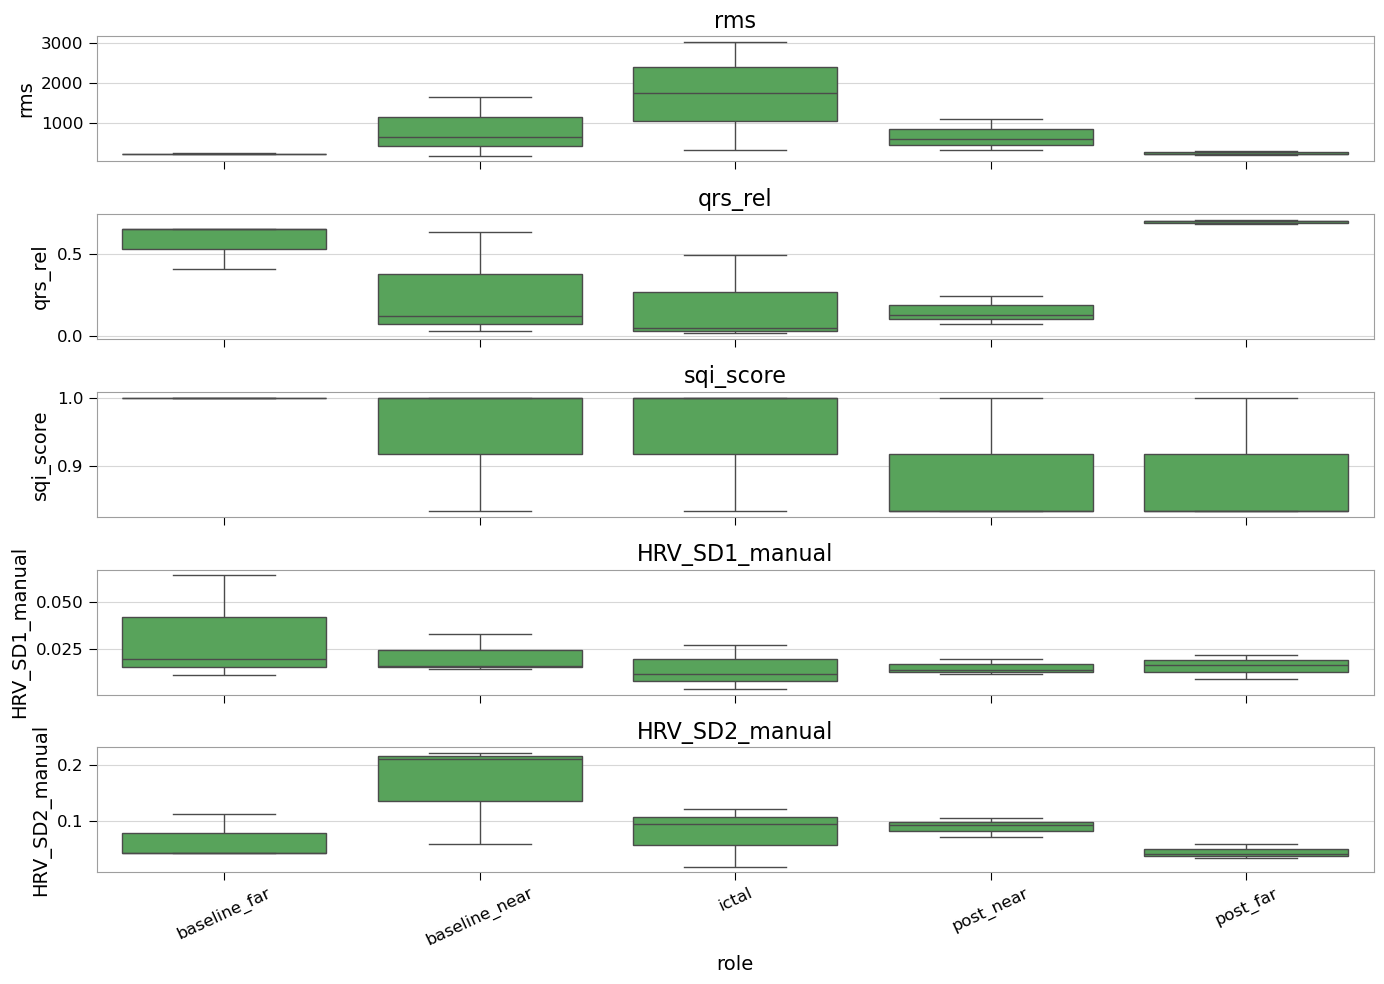

(<Figure size 1400x1000 with 5 Axes>,
 array([<Axes: title={'center': 'rms'}, xlabel='role', ylabel='rms'>,
        <Axes: title={'center': 'qrs_rel'}, xlabel='role', ylabel='qrs_rel'>,
        <Axes: title={'center': 'sqi_score'}, xlabel='role', ylabel='sqi_score'>,
        <Axes: title={'center': 'HRV_SD1_manual'}, xlabel='role', ylabel='HRV_SD1_manual'>,
        <Axes: title={'center': 'HRV_SD2_manual'}, xlabel='role', ylabel='HRV_SD2_manual'>],
       dtype=object))

In [ ]:
from src.hrv_epatch.plots.peri_summary import plot_peri_summary, plot_peri_median_curves

selected_features = [
    "rms",            # noise metric
    "qrs_rel",        # PSD / morphology
    "sqi_score",      # signal quality
    "HRV_SD1_manual", # HRV (short-term variability)
    "HRV_SD2_manual"
]

plot_peri_summary(df_all_hrv, selected_features)


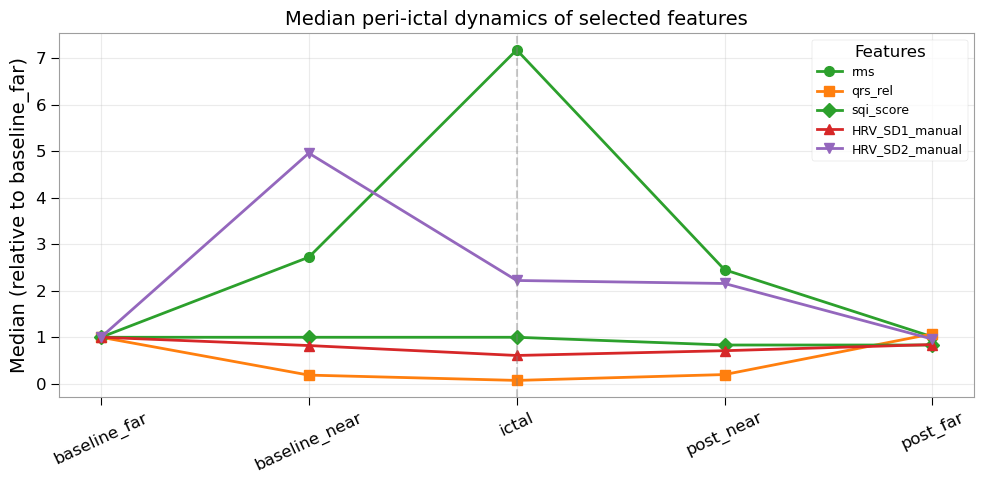

In [ ]:
selected_features = ["rms", "qrs_rel", "sqi_score", "HRV_SD1_manual", "HRV_SD2_manual"]
plot_peri_median_curves(df_all_hrv, selected_features, figsize=(10,5))


Peri-ictal RMS values increased sharply during ictal periods, with both median and mean values peaking substantially in the ictal window.
The difference between median and mean indicates the presence of high-amplitude artefacts (e.g., muscle activation) during seizures.

Short-term HRV metrics (SD1, SD2) were consistently lower during ictal periods, suggesting reduced short-term autonomic variability during the seizure itself.

The ictal window contains a small number of extreme values (artefacts),visible in the mean curve, but largely suppressed in the median curve.

c:\Users\kvjkv\Git1\Epilepsy_MasterThesis\src\hrv_epatch\plots\peri_wavelet.py:88: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


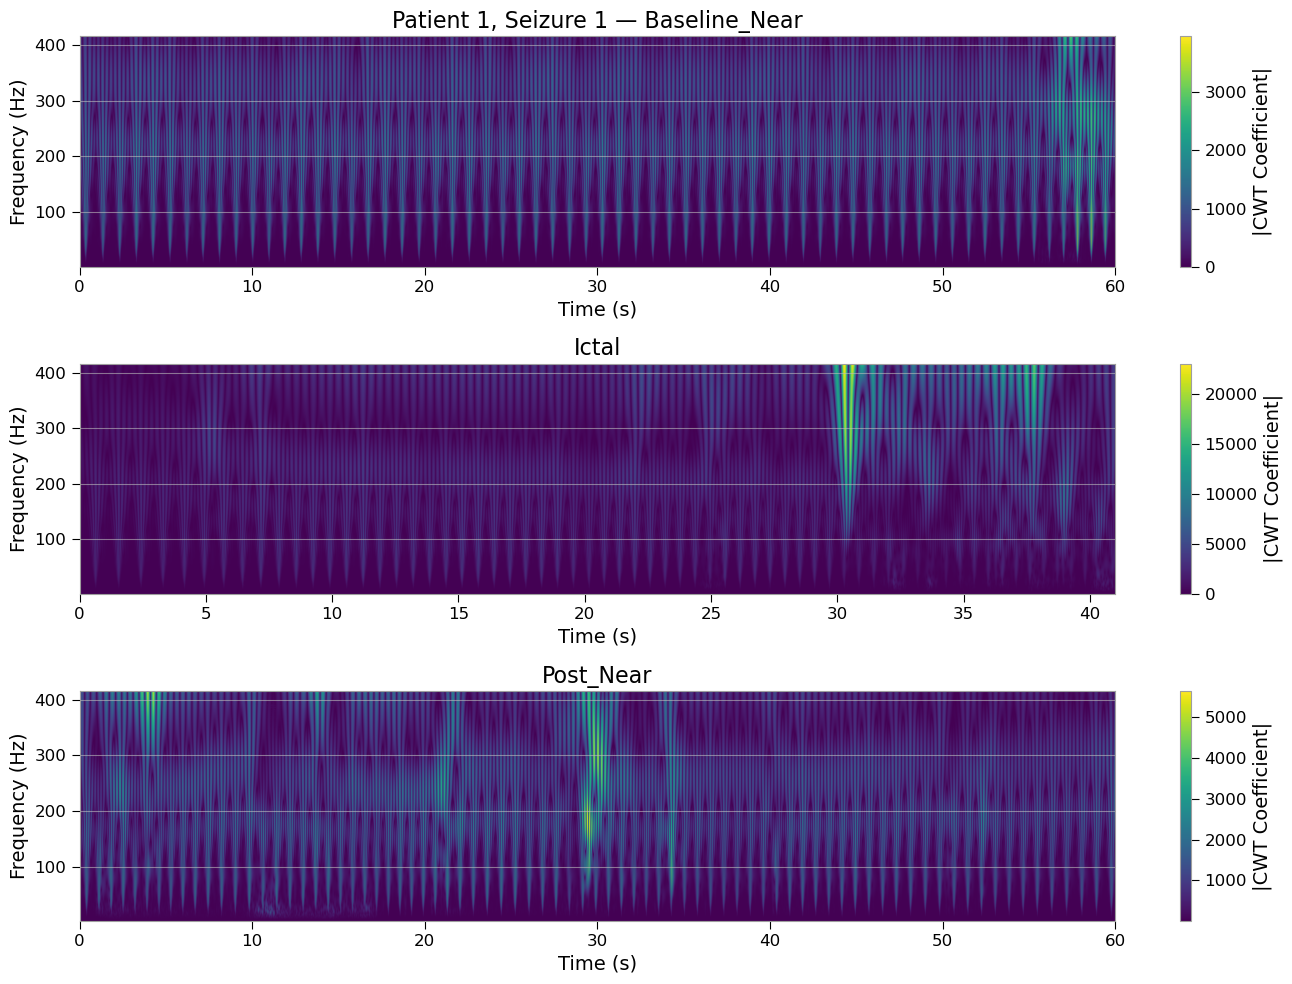

In [ ]:
from src.hrv_epatch.plots.peri_wavelet import plot_peri_cwt_triplet

fs = 512.0
plot_peri_cwt_triplet(df_peri, fs, patient_id=1, seizure_id=1)


Explorativ CWT walkthroug.

In [ ]:
# from src.hrv_epatch.plots.peri_wavelet import plot_peri_cwt_triplet

# fs = 512.0

# unique_seizures = (
#     df_peri[["patient_id", "seizure_id"]]
#     .drop_duplicates()
#     .sort_values(["patient_id", "seizure_id"])
# )

# for _, row in unique_seizures.iterrows():
#     pid = row["patient_id"]
#     sid = row["seizure_id"]
#     print(f"Plotting Patient {pid}, Seizure {sid}")
#     try:
#         plot_peri_cwt_triplet(df_peri, fs, patient_id=pid, seizure_id=sid)
#     except ValueError as e:
#         print("  Skipping:", e)
#         continue
    
#     # stop manuelt hvis du vil:
#     cont = input("Næste? (Enter = ja, q = stop) ")
#     if cont.lower().startswith("q"):
#         break


Alternative CWT analysis for all seizures in all patients and save local.

In [ ]:
from pathlib import Path
from src.hrv_epatch.plots.peri_wavelet import plot_peri_cwt_triplet
from src.hrv_epatch.plots.peri_wavelet_dwt import plot_dwt_triplet

OUT_ROOT = Path(r"E:\Speciale - Results")
OUT_CWT = OUT_ROOT / "cwt_peri"
OUT_DWT = OUT_ROOT / "dwt_peri"
OUT_CWT.mkdir(parents=True, exist_ok=True)
OUT_DWT.mkdir(parents=True, exist_ok=True)

fs = 512.0  # eller df_peri["fs"].iloc[0] hvis du vil læse dynamisk

# Unikke (patient, seizure)-par
unique_seizures = (
    df_peri[["patient_id", "seizure_id"]]
    .drop_duplicates()
    .sort_values(["patient_id", "seizure_id"])
)

print(f"Processing {len(unique_seizures)} seizures...\n")

for _, row in unique_seizures.iterrows():
    pid = int(row["patient_id"])
    sid = int(row["seizure_id"])

    print(f"P{pid:02d} S{sid:02d} ... ", end="")

    # Filnavne
    cwt_path = OUT_CWT / f"CWT_P{pid:02d}_S{sid:02d}.png"
    dwt_path = OUT_DWT / f"DWT_P{pid:02d}_S{sid:02d}.png"

    try:
        # CWT-triple (baseline_near, ictal, post_near)
        plot_peri_cwt_triplet(
            df_peri=df_peri,
            fs=fs,
            patient_id=pid,
            seizure_id=sid,
            save_path=cwt_path,
            show_plot=False,   # <- ingen visning
        )

        # DWT-triple (samme vinduer)
        plot_dwt_triplet(
            df_peri=df_peri,
            fs=fs,
            patient_id=pid,
            seizure_id=sid,
            save_path=dwt_path,
            show_plot=False,   # <- ingen visning
        )

        print("saved.")
    except Exception as e:
        print(f"skipped ({e}).")

print("\nDone.")


Processing 3 seizures...

P01 S01 ... saved.
P01 S02 ... saved.
P01 S03 ... saved.

Done.


## 8. Noise and spectral characteristics

We complement the SQI analysis with PSD-based noise metrics and bandpower
profiles for selected segments / patients.

## 9. Peri-ictal windows around seizures

In addition to the global 60 s segmentation, we construct peri-ictal windows
around each seizure to study how signal characteristics change before, during,
and after clinical events.

We reuse the previous scheme:
- seizure-only windows (matching seizure duration)
- seizure ±2 minutes
- “clean” baseline windows ~20 minutes before seizure

## 10. Case-study plots

Finally, we generate a small number of illustrative plots for selected seizures:
- raw vs cleaned ECG with R-peaks from different detectors
- peri-ictal scalograms / PSD
- segment-level SQI and noise metrics across time

## 11. Export of tables and figures

We finally export the key tables and figures used in the thesis, so that the
LaTeX document can include them directly.